In [1]:
import numpy as np
import pandas as pd
from scipy import spatial
import volpriceinference as vl
import matplotlib as mpl
import seaborn as sns
import logging
import tqdm
from multiprocessing import Pool
import sys

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=3)

In [3]:
logging.captureWarnings(True)
root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)
info_handler = logging.FileHandler('../logging.tmp.txt')
info_handler.addFilter(lambda record: record.levelno <= logging.WARNING)
error_handler = logging.StreamHandler(sys.stderr)
error_handler.addFilter(lambda record: record.levelno > logging.WARNING)
root_logger.addHandler(info_handler)
root_logger.addHandler(error_handler)

In [4]:
vl.__version__

'0.0.11-py36_0'

In [5]:
innov_dim = 250

## Load the data

In [6]:
with pd.HDFStore('../data/spy_daily_estimates_2003-2017_1000_1sec.hdf') as store:
    daily_rtn = store['daily_rtn'] * 252
    vol = store['discrete_vol_est'] * 252**2 
    
    data = pd.concat([daily_rtn, vol.diffusion + vol.jumps], axis=1).dropna()
    data.columns = ['rtn', 'vol']

In [7]:
data.head()

,rtn,vol
2003-01-02,6.419615,8.799756
2003-01-03,0.539956,7.785992
2003-01-06,5.150512,4.586335
2003-01-07,-0.896750,8.294531
2003-01-08,-2.748119,6.446751


In [8]:
data.transform(lambda x: np.sqrt(x) if x.name == 'vol' else x).cov()

,rtn,vol
rtn,5.523276,-0.229847
vol,-0.229847,1.886587


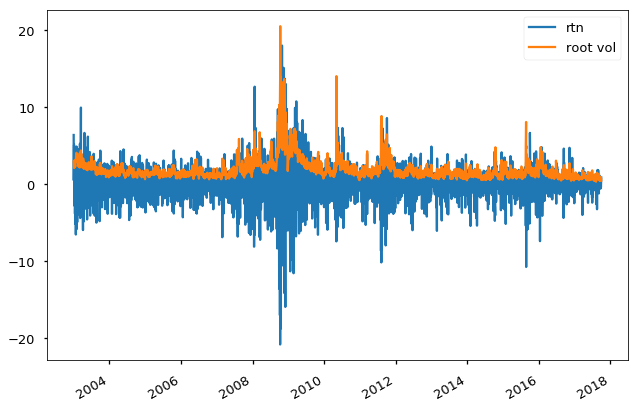

In [9]:
fig1, ax1 = mpl.pyplot.subplots()
data['rtn'].plot(ax=ax1)
data['vol'].apply(np.sqrt).plot(ax=ax1, label='root vol')
ax1.legend()

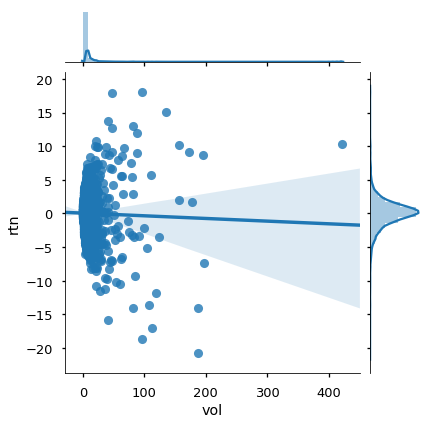

In [10]:
sns.jointplot(x='vol', y='rtn', data=data, kind='reg')

In [11]:
omega, omega_cov = vl.estimate_params_strong_id(data)

In [ ]:
omega

{'gamma': 0.25965685942691796,
 'beta': 0.1113552770767416,
 'psi': -0.15373902507632284,
 'zeta': 0.9086856628806307,
 'delta': 0.2678579804909869,
 'rho': 0.8075059188831978,
 'scale': 3.1120129274168016,
 'phi': -0.3021332298877708,
 'pi': -0.35969605398014043,
 'theta': 0.5278630825503945}

In [ ]:
omega_cov

,beta,delta,gamma,phi,pi,psi,rho,scale,theta,zeta
beta,0.000097,0.000000,-0.000035,NaN,NaN,-0.000091,0.000000,0.000000,NaN,0.000000
delta,0.000000,1.953968,0.000000,NaN,NaN,0.000000,-0.275013,-2.536490,NaN,0.000000
gamma,-0.000035,0.000000,0.000648,NaN,NaN,-0.000080,0.000000,0.000000,NaN,0.000000
phi,NaN,NaN,NaN,9.592997,-2.714527,NaN,NaN,NaN,4.126216,NaN
pi,NaN,NaN,NaN,-2.714527,0.781588,NaN,NaN,NaN,-1.164330,NaN
psi,-0.000091,0.000000,-0.000080,NaN,NaN,0.000149,0.000000,0.000000,NaN,0.000000
rho,0.000000,-0.275013,0.000000,NaN,NaN,0.000000,0.042748,0.326903,NaN,0.000000
scale,0.000000,-2.536490,0.000000,NaN,NaN,0.000000,0.326903,4.739982,NaN,0.000000
theta,NaN,NaN,NaN,4.126216,-1.164330,NaN,NaN,NaN,1.775765,NaN
zeta,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN,0.000431


In [ ]:
data.vol.sort_values(ascending=True).head()

2017-08-07    0.123335
2017-09-14    0.214673
2017-09-22    0.216867
2016-11-25    0.226227
2017-07-24    0.242692
Name: vol, dtype: float64

In [ ]:
omega2, omega_cov2 = vl.estimate_params(data)

In [ ]:
qlr_stats = vl.compute_qlr_stats(omega=omega2, omega_cov=omega_cov2, theta_dim=10, pi_dim=10, phi_dim=10, 
                                 pi_min=-3, pi_max=0, theta_min=0, theta_max=2,  use_tqdm=True)
                               


In [ ]:
omega2

{'gamma': 0.25965685942691796,
 'beta': 0.1113552770767416,
 'psi': -0.15373902507632284,
 'zeta': 0.9086856628806307,
 'delta': 0.2678579804909869,
 'rho': 0.8075059188831978,
 'scale': 3.1120129274168016}

In [ ]:
qlr_draws = vl.compute_qlr_sim(omega=omega2, omega_cov=omega_cov2, theta_dim=10, pi_dim=10, phi_dim=10, 
                               innov_dim=innov_dim, pi_min=-.25, pi_max=0, theta_min=.2, theta_max=.6,
                               use_tqdm=True, alpha=0.05)

In [ ]:
qlr_stats.head()

In [ ]:
qlr_draws.head()

In [ ]:
qlr_draws.to_json(f'../results/qlr_draws_on_data_{innov_dim}_smaller_region.tmp.json')

In [ ]:
accepted_vals = pd.merge(qlr_draws, qlr_stats, right_on=['phi', 'pi', 'theta'], left_on=['phi', 'pi', 'theta'],
         how='outer', suffixes=['_draws', '_stats']).query('qlr_stats < qlr_draws').drop(
    ['qlr_draws', 'qlr_stats'], axis='columns')

In [ ]:
def constraint(scale, psi, zeta, equity_price):
    
    vol_price  = -1 / scale - ((psi * (equity_price-1) + zeta/2 * (equity_price-1)**2))
    
    return  vol_price

In [ ]:
accepted_vals

In [ ]:
fig3, ax3 = mpl.pyplot.subplots()
ax3.scatter(y=accepted_vals.theta, x=accepted_vals.pi, marker='o', s=60, label='Confidence Region')
ax3.set_xlim([-3.5, .5])
ax3.set_ylim([-.5, 3.5])
yvals = np.linspace(0,5,100)
xvals = [constraint(omega['scale'], omega['psi'], omega['zeta'], x) for x in yvals]
ax3.plot(xvals, yvals, color='orange', label='Constraint')
ax3.axvline(0,  ymin=.5 /6, ymax=1 - .5/6, color='black')
ax3.axvline(-15,  ymin=.5 /6, ymax=1 - .5/6, color='black')
ax3.axhline(0,  xmin=.5 /16, xmax=1 - .5/16, color='black')
ax3.axhline(5,  xmin=.5 /16, xmax=1 - .5/16, color='black')
ax3.legend()
ax3.set_ylabel('Equity Price')
ax3.set_xlabel('Volatility Price')
fig3.savefig('../doc/figures/confidence_region.tmp.pdf', frameon=False, pad_inches=0, bbox_inches='tight',
            transparent=True)

In [ ]:
accepted_vals.min()

In [ ]:
accepted_vals.max()